In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Data Importing

#### Import Demand Data

In [8]:
population = 7.229*(10**6)
demandPC = pd.read_csv('demand_data.csv', delimiter=',')
demand = demandPC.rename(columns={'kWh per capita':'MWh'})

demand['MWh'] = demand['MWh']*population/1000
print(demand)

      hour          MWh
0        0  4239.627775
1        1  4117.096225
2        2  3876.280163
3        3  3661.880071
4        4  3517.541038
...    ...          ...
8779  8779  5263.585504
8780  8780  5459.672129
8781  8781  5323.435600
8782  8782  5029.636992
8783  8783  4586.800500

[8784 rows x 2 columns]


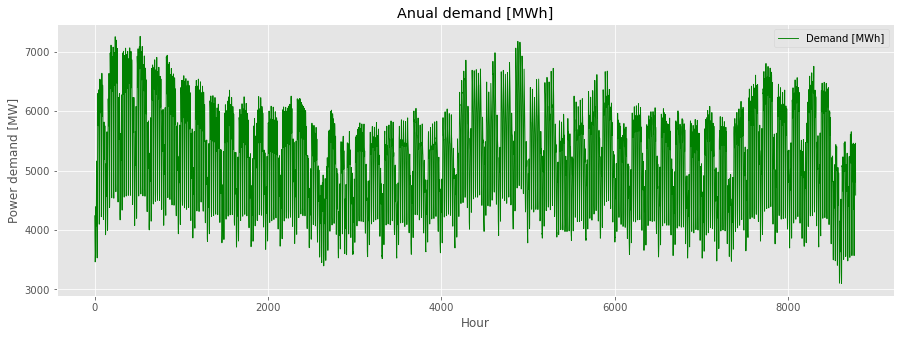

In [9]:
plt.style.use('ggplot')
plt.figure(figsize=(15,5))
plt.plot(demand['hour'], demand['MWh'], linewidth=0.9, color= 'g', label='Demand [MWh]')

plt.title('Anual demand [MWh]')
plt.xlabel('Hour')
plt.ylabel('Power demand [MW]')
plt.legend()

plt.savefig('Demand_Plot.png')
plt.show()


In [10]:
# plotly library for interacive plots
import plotly.offline as py
from plotly import tools
import plotly.graph_objs as go
import warnings
from ipywidgets import widgets
from ipywidgets import interact

# plotly settings to ignore warnings
warnings.filterwarnings('ignore')
py.init_notebook_mode(connected=True)

# create traces
trace1 = go.Scatter(
             x = demand['hour'],
             y = demand['MWh'],
             mode = 'lines',
             name = 'Demand')




# create figure
fig = go.Figure(data=[trace1])
# show figure
fig.show(renderer="colab")

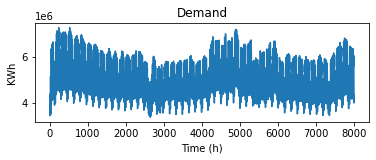

In [32]:


fig = plt.figure()
ax1 = fig.add_subplot(211)
ax1.set_ylabel('KWh')
ax1.set_xlabel('Time (h)')
ax1.set_title('Demand')

line, = ax1.plot(demand['hour'][1:8000],demand['kWh'][1:8000])

#### Import Renewable Data

In [41]:
NASAdat = pd.read_csv('data/POWER_Point_Hourly_20200101_20201231_030d7333N_098d2000E_LST.csv',skiprows=11)
print(NASAdat)



      YEAR  MO  DY  HR  ALLSKY_SFC_SW_DWN     SZA  WS50M
0     2020   1   1   7              22.57   88.30   3.75
1     2020   1   1   8             183.16   78.51   3.49
2     2020   1   1   9             392.67   68.75   4.65
3     2020   1   1  10             557.15   60.83   5.85
4     2020   1   1  11             655.19   55.55   6.34
...    ...  ..  ..  ..                ...     ...    ...
8779  2021   1   1   2               0.00 -999.00   2.61
8780  2021   1   1   3               0.00 -999.00   2.59
8781  2021   1   1   4               0.00 -999.00   2.66
8782  2021   1   1   5               0.00 -999.00   2.73
8783  2021   1   1   6               0.00 -999.00   2.83

[8784 rows x 7 columns]


numpy.float64

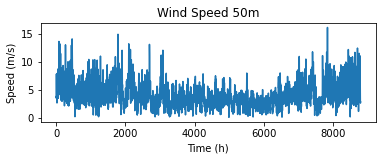

In [34]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
ax1.set_ylabel('Speed (m/s)')
ax1.set_xlabel('Time (h)')
ax1.set_title('Wind Speed 50m')

line, = ax1.plot(NASAdat['WS50M'])

Calculation of the wind speed at 140m

In [35]:
h1 = 50 # m
h2 = 140 # m
z0 = 1.6 # m
k = (np.log(h2/z0))/(np.log(h1/z0))
WS140M = NASAdat['WS50M']*k


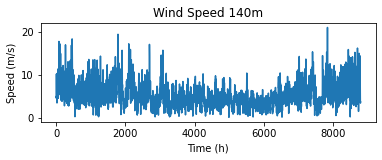

In [36]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
ax1.set_ylabel('Speed (m/s)')
ax1.set_xlabel('Time (h)')
ax1.set_title('Wind Speed 140m')

line, = ax1.plot(WS140M)

## Calculate Generation

#### Solar

In [37]:
class SolarPower:
    def __init__(self, 
                invEff = 0.96,
                ratedPower = 110, #W
                area = 0.82 #m²
                ):
        
        panelEff = ratedPower/(1000*area) # rated power calc at 1000 W/m²
        self.k =panelEff*area*invEff/1000
   

    def calculate(self,irradiance,SZA):
        
        pSolar=irradiance*self.k
        
        if SZA<85:
            return pSolar 
        else:
            return 0
        

a = SolarPower()


In [50]:
solarProduction = pd.DataFrame(columns=['solarPower'])
solarProduction

panel=SolarPower()
b=[]
for i in range(0,len(NASAdat)):
   b[i]=panel.calculate(irradiance = NASAdat["ALLSKY_SFC_SW_DWN"][i],SZA=NASAdat["SZA"][i])

solarProduction



IndexError: list assignment index out of range

#### Wind

Calculation of the wind speed at 140m

In [ ]:
h1 = 50 # m
h2 = 140 # m
z0 = 1.6 # m
k = (np.log(h2/z0))/(np.log(h1/z0))
WS140M = NASAdat['WS50M']*k

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
ax1.set_ylabel('Speed (m/s)')
ax1.set_xlabel('Time (h)')
ax1.set_title('Wind Speed 140m')

line, = ax1.plot(WS140M)

Turbine Power Curve

In [ ]:
WS = np.linspace(3,30,28)
PowerCurve = [61,188,434,823,1355,2037,2843,3667,4337,4742,4921,4980,4996,4999,4996,
                4979,4931,4833,4678,4477,4247,4006,3763,3528,3309,3114,2952,2828] # en kW

fig, ax = plt.subplots()
ax.plot(WS,PowerCurve,)
plt.show()

Calculate Power and Export

In [ ]:
TurbineProduction = pd.DataFrame(columns=['Power_kW'])
TurbineProduction['Power_kW'] = np.interp(WS140M,xp = WS,fp = PowerCurve,left=0,right=0)

# Export
TurbineProduction.to_csv('data/SingTurbProduction.csv')